For a Russian airline that performs domestic passenger transportation, it is important to understand the preferences of users who buy tickets to different destinations.

## Task:
- upload and prepare airline data using SQL,
- test the hypothesis about the difference in the average demand for tickets during different events.

## Description of the data
At your disposal is a database about air transportation.

Для российской авиакомпании, выполняющей внутренние пассажирские перевозки важно понять предпочтения пользователей, покупающих билеты на разные направления.

## Задача: 
 - произвести выгрузки и подготовку данных авиакомпании с помощью SQL,
 - проверить гипотезу о различии среднего спроса на билеты во время различных событий.
 
## Описание данных
В вашем распоряжении база данных об авиаперевозках.  


# Working with a database using SQL / Работа с базой данных средствами SQL

1. Find the number of flights of each aircraft model with departure in September 2018.   
Найти количество рейсов каждой модели самолёта с вылетом в сентябре 2018 года. 

```
SELECT
   aircrafts.model,
   COUNT(flights.flight_id) AS flights_amount
FROM flights
INNER JOIN aircrafts ON aircrafts.aircraft_code =flights.aircraft_code
WHERE EXTRACT(MONTH FROM departure_time) = '09' AND EXTRACT(YEAR FROM departure_time) = '2018'
GROUP BY aircrafts.model
```
2. Calculate the flights of the following aircraft models in September:  
Посчитать отправленные в сентябре рейсы самолётов следующих моделей:
     - Boeing,
     - Airbus,
     - другие (“other”).
     
```
SELECT 
    CASE
        WHEN model LIKE '%Boeing%' THEN 'Boeing'
        WHEN model LIKE '%Airbus%' THEN 'Airbus'
        ELSE 'other'
    END AS model_1,
    COUNT(*) AS flights_amount
FROM flights
INNER JOIN aircrafts ON aircrafts.aircraft_code=flights.aircraft_code
WHERE  EXTRACT(MONTH FROM flights.departure_time)='09'
GROUP BY model_1
```

3. Calculate the average number of incoming flights per day for each city for August 2018.  
Посчитать среднее количество прибывающих рейсов в день для каждого города за август 2018 года.

```
SELECT
    subq.city,
    AVG(subq.cnt) AS average_flights
FROM
(SELECT
    EXTRACT(DAY FROM arrival_time),
    city,
    COUNT(flights.flight_id) AS cnt
FROM flights
INNER JOIN airports ON airports.airport_code=flights.arrival_airport
WHERE
    EXTRACT(MONTH FROM flights.departure_time)='08' 
    AND EXTRACT(YEAR FROM flights.departure_time)='2018'
GROUP BY city, EXTRACT(DAY FROM arrival_time)) AS SUBQ
GROUP BY subq.city
```

4. Find the festivals that took place from July 23 to September 30, 2018 in Moscow, and the number of the week in which they took place.  
Найти фестивали, которые проходили с 23 июля по 30 сентября 2018 года в Москве, и номер недели, в которую они проходили.

```
SELECT
    festival_name,
    EXTRACT(WEEK FROM festival_date) AS festival_week
FROM festivals
WHERE festival_date BETWEEN '2018-07-23' and '2018-09-30'
    AND festival_city='Москва'
```
    
5. For each week from July 23 to September 30, 2018, count the tickets to Moscow. Get a table:  
Для каждой недели с 23 июля по 30 сентября 2018 года посчитать билеты на рейсы в Москву. Получить таблицу:
 - с количеством купленных за неделю билетов;
 - отметкой, проходил ли в эту неделю фестиваль;
 - название фестиваля festival_name;
 - номер недели week_number.

```
SELECT 
    SUBQ.week_number,
    SUBQ.ticket_amount,
    CASE
        WHEN SUBQ.festival_week IS NULL THEN NULL
        ELSE SUBQ.festival_week
        END AS festival_week,
    CASE
        WHEN SUBQ.festival_name IS NULL THEN NULL
        ELSE SUBQ.festival_name
        END AS festival_name



FROM 
((SELECT
     EXTRACT(WEEK FROM arrival_time::date) AS week_number,
     COUNT(ticket_no) AS ticket_amount
FROM flights
    INNER JOIN airports ON airports.airport_code = flights.arrival_airport
    INNER JOIN ticket_flights ON flights.flight_id = ticket_flights.flight_id
WHERE CAST(flights.departure_time AS DATE) BETWEEN '2018-07-23' AND '2018-09-30'
     AND airports.city = 'Москва'
GROUP BY week_number
ORDER BY week_number) AS SUBQ1

LEFT JOIN 
(SELECT         
        festival_name,  
        EXTRACT (WEEK FROM festivals.festival_date::date) AS festival_week
    FROM 
        festivals
    WHERE
        festival_city = 'Москва'
      AND festivals.festival_date::date BETWEEN '2018-07-23' AND '2018-09-30'
) AS SUBQ2
ON SUBQ1.week_number = SUBQ2.festival_week) AS SUBQ
ORDER BY week_number
```

# Analytics with Python
Examine the data obtained as a result of queries from the previous task.

## Check the hypothesis:
The average demand for tickets during festivals does not differ from the average demand for tickets at normal times.  

# Аналитика средствами Python
Изучить данные, полученные в результате запросов из предыдущего задания.


## Проверка гипотезы:
Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время.

## Content
1. [Analytics](#1)
2. [Hypothesis Testing](#2)
3. [Conclusions](#3)

## Содержание
1. [Аналитика](#1)
2. [Проверка гипотезы](#2)
3. [Выводы](#3)

<a id='1'></a>

# 1. Analytics / Аналитика

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
query_1 = pd.read_csv("/datasets/query_1.csv")
query_3 = pd.read_csv("/datasets/query_3.csv")
query_last = pd.read_csv("/datasets/query_last.csv")

In [3]:
query_1.head()
query_1.info()

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


The table has 8 rows, two columns (aircraft models and the number of flights for each aircraft model in September 2018), there are no missing values, the data types correspond to the content of the columns.   
В таблице 8 строк, два столбца (модели самолетов и  количество рейсов для каждой модели самолетов в сентябре 2018 года), пропусков нет, типы данных соответствуют содержимому столбцов.

In [4]:
query_3.head()
query_3.info()

,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


The table has 101 rows, two columns (city names and the average number of flights arriving in the city per day in September 2018), there are no missing values, the data types correspond to the content of the columns.  
В таблице 101 строка, два столбца (названия городов и среднее количество рейсов, прибывающих в город за день в сентябре 2018 года), пропусков нет, типы данных соответствуют содержимому столбцов.

In [5]:
query_last.head()
query_last.info()

,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
2,32,51675,NaN,NaN
3,33,51378,NaN,NaN
4,34,51492,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
week_number      10 non-null int64
ticket_amount    10 non-null int64
festival_week    3 non-null float64
festival_name    3 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 448.0+ bytes


The table has 10 rows, 4 columns:
- *week_number* — week number;
- *ticket_amount* — number of tickets sold per week;
- *festival_week* — is there a festival this week;
- *festival_name* — name of the festival,
The *festival_week * column is of the float64 type, since it has missing values, the *festival_name* column also has missing values.  

В таблице 10 строк, 4 столбца:  
- *week_number* — номер недели;
- *ticket_amount* — количество проданных билетов за неделю;
- *festival_week* — есть ли на этой неделе фестиваль;
- *festival_name* — название фестиваля,  
Столбец *festival_week* — типа float64, поскольку в нем есть пропущенные значения, в столбце *festival_name* также есть пропуски.

#### Let's see check models of aircraft made the most flights in September.  
#### Посмотрим, какие модели самолеты совершали в сентябре больше всего рейсов.

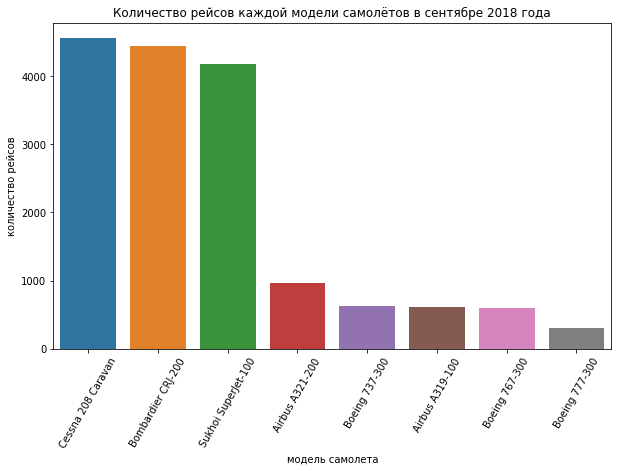

In [6]:
plt.figure(figsize=(10, 6))
plt.title("Количество рейсов каждой модели самолётов в сентябре 2018 года")
sns.barplot(
    data=query_1.sort_values(by="flights_amount", ascending=False),
    x="model",
    y="flights_amount",
)
plt.xlabel("модель самолета")
plt.ylabel("количество рейсов")
plt.xticks(rotation=60)
plt.show();

The leaders are - "Cessna 208 Caravan", "Bombardier CRJ-200" and "Sukhoi SuperJet-100".
- Cessna 208 Caravan-light single-engine turboprop general purpose aircraft used for regional and local air transport, with a capacity of up to 13 passengers,
- Bombardier CRJ-200-used for regional air transport, with a capacity of up to 50 passengers,
- Sukhoi SuperJet-100 is a Russian short-haul passenger aircraft designed to carry from 87 to 108 passengers over distances of 3050-4600 km.
Next come:
- Airbus A321-200 in fourth place, airliner for short and medium-haul airlines, passenger capacity 140 to 180 people, flight range up to 6150km,
- Boeing 737-300 in fifth place, the same class as Airbus A321-200-short-and medium-haul airliner, 108-168 passengers, flight range 4200 km,
- Airbus A319-100-modification of Airbus A320, passenger capacity 116-156 people, flight range 6850 km,
These are models of aircraft of the same class with a similar number of passengers and flight range.
And, finally, the least flights were made:
- Boeing 767-300-airliner designed for medium and long-haul flights, passenger capacity from 218 to 350 people, range 9700 km,
- Boeing 777-300 airliner for long-distance flights, passenger capacity up to 550 people, flight range up to 11,120 kilometers.
That is, most often flew small aircraft designed for regional and local air transport. In the absence of source tables, it is not possible to see between which cities they flew, but most often these are small cities not in the European part of the country. The larger the aircraft, the greater the passenger capacity and the greater the possible range of flights, the fewer flights the aircraft made.

In this case, it is interesting to look at the number of passengers transported and compare it by this characteristic, as well as look at the geography of flights for these models, but, unfortunately, there are no tables available.

Лидеры по количеству рейсов  - 'Cessna 208 Caravan', 'Bombardier CRJ-200' и 'Sukhoi SuperJet-100'.  
 - Cessna 208 Caravan - лёгкий одномоторный турбовинтовой самолёт общего назначения, используемый для региональных и местных воздушных перевозок, вместимостью до 13 пассажиров,
 - Bombardier CRJ-200 - используется для региональных воздушных перевозок, вместимостью до 50 пассажиров,
 - Sukhoi SuperJet-100 -  российский ближнемагистральный пассажирский самолёт, предназначенный для перевозки от 87 до 108 пассажиров на расстояния 3050-4600 км.  
Далее идут:
 - Airbus A321-200 на четвертом месте, авиалайнер для авиалиний малой и средней протяжённости, пассажировместимость 140 до 180 человек, дальность перелетов до 6150км,
 - Boeing 737-300 на пятом месте, того же класса, что и Airbus A321-200 - ближне- и среднемагистральный авиалайнер, 108-168 пассажиров, дальность полетов 4200 км,
 - Airbus A319-100 - модификация Airbus A320, пассажировместимость 116 - 156 человек,  дальность полетов 6850км,
Это модели самолетов одинакового класса с похожим количеством пассажиров и дальностью перелетов.  
И, наконец, меньше всего полетов совершили:
 - Boeing 767-300 - авиалайнер, предназначенный для совершения полётов средней и большой протяжённости, пассажировместимость от 218 до 350 человек, дальность 9700км,
 - Boeing 777-300 авиалайнер для совершения полётов большой протяжённости, пассажировместимость до 550 человек, дальность полетов до 11 120 километров.
То есть чаще всего летали небольшие самолеты, предназначенные для региональных и местных воздушных перевозок. При отсутствии исходных таблиц нет возможности посмотреть, между какими городами они выполняли полеты, но скоре всего это небольшие города не в европейской части страны.  Чем больше самолет, больше пассажировместимость и больше возможная дальность перелетов, тем меньше рейсов совершали самолеты.

В данном случае интересно посмотреть на количество перевезенных пассажиров и сравнить по этой характеристике,  а также посмотреть на географию полетов для этих моделей, но, к сожалению, нет доступных таблиц.

#### Let's look at the top 10 cities by the average number of flights arriving in the city per day in September 2018.:  
#### Посмотрим топ-10 городов по среднему количеству рейсов, прибывающих в город за день в сентябре 2018 года.: 

In [7]:
top_10 = query_3.sort_values(by="average_flights", ascending=False).head(10)
top_10

,city,average_flights
43,Москва,129.774194
70,Санкт-Петербург,31.161290
54,Новосибирск,17.322581
33,Красноярск,11.580645
20,Екатеринбург,11.322581
67,Ростов-на-Дону,10.193548
63,Пермь,10.129032
10,Брянск,10.000000
74,Сочи,9.612903
84,Ульяновск,9.580645


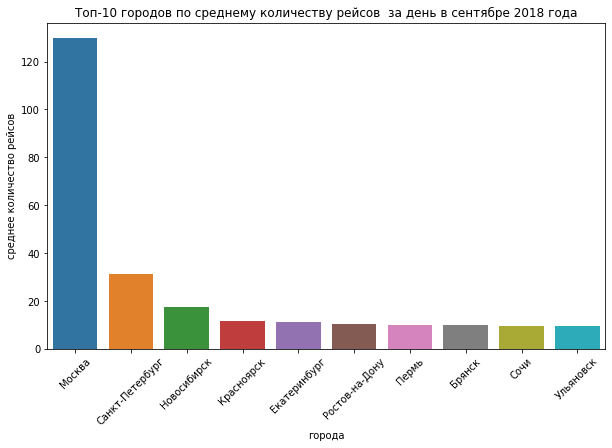

In [8]:
plt.figure(figsize=(10, 6))
plt.title("Топ-10 городов по среднему количеству рейсов  за день в сентябре 2018 года")
sns.barplot(data=top_10, x="city", y="average_flights")
plt.xlabel("города")
plt.ylabel("среднее количество рейсов")
plt.xticks(rotation=45)
plt.show();

Moscow is in the first place, on average 129.77 flights arrived per day in September 2018, in second place - St. Petersburg (31.16 flights), in third - Novosibirsk (17.32 flights). Moscow is not only the largest city, it is also often a connecting city for flights with transfers, so, apparently, although the population of Moscow is 2.2 times larger than St. Petersburg, there are 4.2 times more flights to Moscow. The population of St. Petersburg is 2 times larger than the population of Novosibirsk, and 1.8 times more flights arrive there.
Then there are Krasnoyarsk (11.6 flights), Yekaterinburg (11.3), Rostov-on-Don (10.2) and Perm (10) - cities with a population of more than a million people, then - Bryansk (10 flights), Sochi (9.6) and Ulyanovsk (9.6) - cities with a population of 400-600 thousand people.

Here it would also be interesting to look at the number of arrivals, and not just the number of flights, since the planes have different capacities, but we do not have such information.  

На первом месте Москва - в среднем в сентябре 2018 года прилетало 129.77 рейсов в день, на втором месте - Санкт-Петербург (31.16 рейсов), на третьем - Новосибирск (17.32 рейсов). Москва - не только самый крупный город, он также часто является стыковочным при полетах с пересадками, поэтому, видимо, хоть население Москвы в 2,2 раза больше Санкт-Петербурга, прилетает в Москву в 4,2 раза больше рейсов. Население Санкт-Петербурга в 2 раза больше населения Новосибирска, прилетает в него в 1,8 раз больше рейсов.    
Дальше идут Красноярск (11,6 рейсов), Екатеринбург (11,3), Ростов-на-Дону (10,2) и Пермь (10) - города с населением больше миллиона человек, дальше - Брянск (10 рейсов), Сочи (9,6) и Ульяновск (9,6) - города с населением 400-600тыс человек.  

Тут было бы еще интересно помсмотреть на количество прилетающих, а не только на количество рейсов, так как самолеты разной вместимости, но такой информации у нас нет.

#### Plot of the average amount of flights per day for all cities in September 2018.
#### График среднего количества рейсов в день для всех городов в сентябре 2018 года.

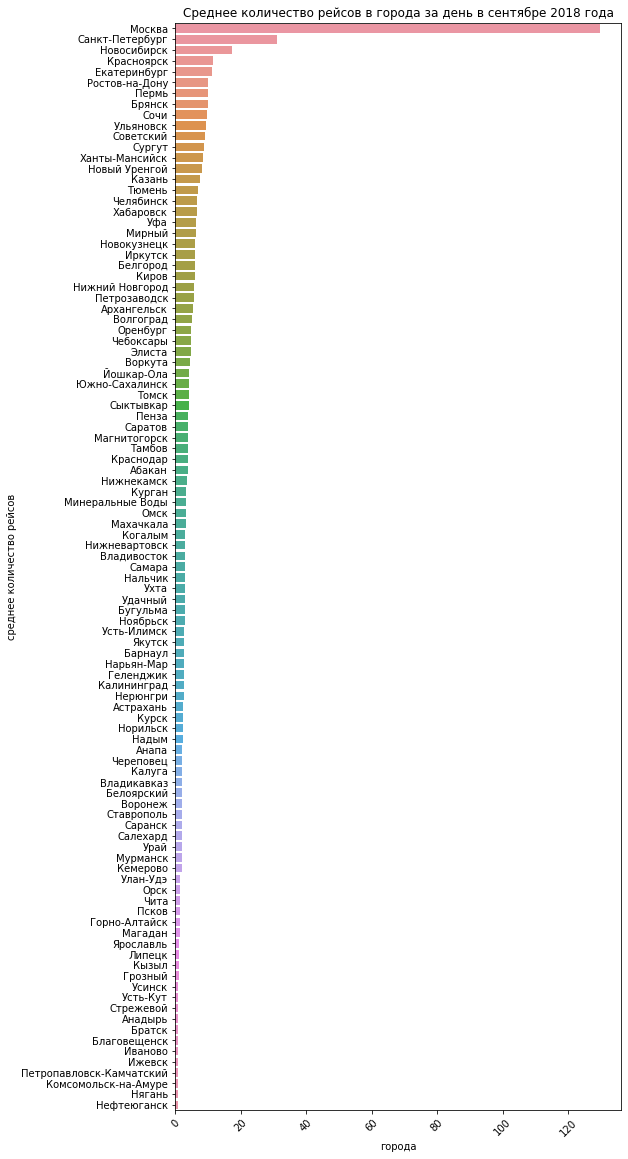

In [9]:
plt.figure(figsize=(8, 20))
plt.title("Среднее количество рейсов в города за день в сентябре 2018 года")
sns.barplot(
    data=query_3.sort_values(by="average_flights", ascending=False),
    y="city",
    x="average_flights",
)
plt.xlabel("города")
plt.ylabel("среднее количество рейсов")
plt.xticks(rotation=45)
plt.show();

Without data on the population, the amount of arrivals, the types of aircraft and the availability of other communication with these cities, it is difficult to say anything. For example, on the 11th place - the city of Sovetsky in the Khanty-Mansi Autonomous Okrug with a population of only 29,000 people, but  there are about the same number of flights as to Ulyanovsk.  

Без данных о населении, количестве прилетающих, типах самолетов и наличии другого сообщения с этими городами сложно что-либо сказать. Например, на 11 месте - город Советский в Ханты-Мансийском автономном округе с населением всего 29000 человек, но рейсов там примерно как в Ульяновске.

<a id='2'></a>

# 2. Проверка гипотезы

#### Hypothesis:
the average demand for tickets during festivals does not differ from the average demand for tickets at normal times.  

#### Гипотеза:
средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время.


Let's look at the data:  
Посмотрим на таблицу:

In [10]:
query_last

,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
2,32,51675,NaN,NaN
3,33,51378,NaN,NaN
4,34,51492,NaN,NaN
5,35,51360,NaN,NaN
6,36,51386,36.0,Видфест
7,37,51670,NaN,NaN
8,38,51518,NaN,NaN
9,39,51623,NaN,NaN


Only 10 rows.  
We have very little data, only three weeks with festivals and 7 without, these data are part of one general population, for statistical analysis and hypothesis testing it is catastrophically small, but what is, that is.

Всего 10 строк.  
У нас очень мало данных, всего три недели с фестивалями и 7 без, эти данные являются частью одной генеральной совокупности, для статистического анализа и проверок гипотез это катастрофически мало, но что есть, то есть. 

Let's formulate hypotheses:
___Null hypothesis___:
- the average demand for tickets during festivals is equal to the average demand for tickets at regular times,

___Alternative hypothesis___:
- the average demand for tickets during festivals is different from the average demand for tickets at normal times.

The hypothesis is two-sided, since we are not interested in whether the demand is greater or less. Set the significance level alpha = 0.05.

First we need to check the distribution type. Let's separate the number of tickets during festivals and at normal times.  

Сформулируем гипотезы:  
___Нулевая гипотеза___:
 - средний спрос на билеты во время фестивалей равен среднему спросу на билеты в обычное время,  
 
___Альтернативная гипотеза___:
 - средний спрос на билеты во время фестивалей отличается от среднего спроса на билеты в обычное время.  

Гипотеза двусторонняя, поскольку нас не интересует, больше спрос или меньше. Установим уровень значимости alpha = 0.05.  

Для начала нужно проверить тип распределения. Отделим количество билетов во время фестивалей и в обычное время.

In [11]:
alpha = 0.05

In [12]:
all_flights = query_last.ticket_amount.values  ## all tickets
flights_festivals = query_last[query_last["festival_week"].notna()].ticket_amount.values
flights_no_festivals = query_last[
    query_last["festival_week"].isna()
].ticket_amount.values

In [13]:
flights_festivals
flights_no_festivals

array([43568, 51034, 51386])

array([51675, 51378, 51492, 51360, 51670, 51518, 51623])

## Check for the normality of the distribution (Gaussian distribution)
___Null hypothesis: the data is distributed normally, the alternative is that the distribution is different from the normal one.___  

### D'Agostino Test  
 
This test does not work when the number of data is less than 8, so you can not check separately arrivals in the weeks of festivals and without. We will check the arrivals for the entire period of time, since they are part of the same general population.

## Проверка на нормальность распределения (распределение Гаусса)
___Нулевая гипотеза: данные распределены нормально, альтернативная - распределение отличается от нормального.___  

### Тест Д'Агостино  
 
Этот тест не работает при количестве данных меньше 8, поэтому нельзя проверить отдельно прилеты в недели фестивалей и без. Проверим  прилеты за весь промежуток времени, поскольку они являются частью одной генеральной совокупности.

In [14]:
print("Все прилеты")
_, p = st.normaltest(all_flights)

print("p = {:g}".format(p))
# null hypothesis: x comes from a normal distribution
if p < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

Все прилеты
p = 7.80453e-07
The null hypothesis can be rejected


According to D'Agostino's criterion, the null hypothesis can be rejected, apparently, the distribution is different from the normal one.

Let's try other tests for the normality of the distribution.  

Согласно критерию Д'Агостино, нулевая гипотеза может быть отклонена, по всей видимости, распределение отличается от нормального.  

Попробуем другие тесты на нормальность распределения.

### Shapiro-Wilk test for the normality of the distribution (Gaussian distribution).  
### Тест Шапиро-Уилка - проверка на нормальность распределения (распределение Гаусса). 


In [15]:
print("Спрос на билеты во время фестивалей")
_, p = st.shapiro(flights_festivals)
print("p = {:g}".format(p))
# null hypothesis: x comes from a normal distribution
if p < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

print("\nСпрос на билеты в обычное время")
_, p = st.shapiro(flights_no_festivals)
print("p = {:g}".format(p))
# null hypothesis: x comes from a normal distribution
if p < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

Спрос на билеты во время фестивалей
p = 0.0761427
The null hypothesis cannot be rejected

Спрос на билеты в обычное время
p = 0.296301
The null hypothesis cannot be rejected


According to the results of the Shapiro-Wilk test, the null hypothesis about the normality of the distribution cannot be rejected at the significance level of 0.05, that is, there is reason to assume that both samples are distributed normally.    
Согласно результатам теста Шапиро-Уилка нулевая гипотеза о нормальности распределение не може быть отклонена на уровне значимости 0.05, то есть есть основания предполагать, что обе выборки распределены нормально.

### Anderson-Darling test  
### Тест Андерсона-Дарлинга


In [16]:
print("Спрос на билеты во время фестивалей")
result = st.anderson(flights_festivals, dist="norm")
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print("Распределение нормальное при уровне значимости %.1f%%" % (sl))
    else:
        print("Распределение не нормальное при уровне значимости %.1f%%" % (sl))

print("\nСпрос на билеты в обычное время")
result = st.anderson(flights_no_festivals, dist="norm")
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print("Распределение нормальное при уровне значимости %.1f%%" % (sl))
    else:
        print("Распределение не нормальное при уровне значимости %.1f%%" % (sl))

Спрос на билеты во время фестивалей
Распределение не нормальное при уровне значимости 15.0%
Распределение не нормальное при уровне значимости 10.0%
Распределение не нормальное при уровне значимости 5.0%
Распределение не нормальное при уровне значимости 2.5%
Распределение не нормальное при уровне значимости 1.0%

Спрос на билеты в обычное время
Распределение нормальное при уровне значимости 15.0%
Распределение нормальное при уровне значимости 10.0%
Распределение нормальное при уровне значимости 5.0%
Распределение нормальное при уровне значимости 2.5%
Распределение нормальное при уровне значимости 1.0%


According to the results of Anderson-Darling test, the null hypothesis about the normality of the distribution cannot be rejected at a significance level of 0.05 for a sample with tickets at regular times, that is, there is reason to assume that it is distributed normally.

For a sample with tickets during festivals, the null hypothesis can be rejected, apparently,the distribution is different from normal, although the sample consists of only three observations and it is difficult to talk about normality here.

Since it is impossible to say unambiguously about the normality of the distribution based on the results obtained, we use parametric and nonparametric statistical tests for independent samples.  
Our hypotheses again:  
___Null hypothesis:___
- the average demand for tickets during festivals is equal to the average demand for tickets at normal times,

___Alternative hypothesis:___
- the average demand for tickets during festivals differs from the average demand for tickets at normal times.



Согласно результатам теста Андерсона-Дарлинга нулевая гипотеза о нормальности распределение не може быть отклонена на уровне значимости 0.05 для выборки с билетами в обычное время, то есть есть основания предполагать, что она  распределена нормально.

Для выборки с билетами во время фестивалей нулевая гипотеза может быть отклонена, по всей видимости, распределение отличается от нормального,хотя выборка состоит всего из трех наблюдений и говорить о нормальности тут сложно.

Поскольку на основании полученных результатов нельзя сказать однозначно о нормальности распределения, то используем параметрические и непараметрические статистические тесты для независимых выборок.  
Еще раз гипотезы:   
___Нулевая гипотеза:___
 - средний спрос на билеты во время фестивалей равен среднему спросу на билеты в обычное время,  
 
___Альтернативная гипотеза:___
 - средний спрос на билеты во время фестивалей отличается от среднего спроса на билеты в обычное время. 



### t-Student's criterion
Criterion for for independent samples with normal distribution  
### t-критерий Стьюдента 
Критерий для для независимых выборок c нормальным распределением

In [17]:
p_value = st.ttest_ind(flights_no_festivals, flights_festivals).pvalue

print("p_value = {:.4f}".format(p_value))
if p_value < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p_value = 0.0969
The null hypothesis cannot be rejected


According to the Student's t-test, null hypothesis cannot be rejected at a significance level of 0.05. That is, there is reason to assume that the average demand for tickets during festivals is equal to the average demand for tickets on normal days.  

Согласно t-критерию Стьюдента нулевая не может быть отклонена на уровне значимости 0,05. То есть есть основания предполагать, что средний спрос на билеты во время фестивалей равен среднему спросу на билеты в обычные дни.

### Mann-Whitney criterion
A nonparametric alternative to  t-test for independent samples whose distribution differs from the normal one.  
### Критерий Манна-Уитни 
Непараметрическая альтернатива t-критерия для независимых выборок, распределение которых отличается от нормального.

In [18]:
p_value = st.mannwhitneyu(flights_no_festivals, flights_festivals).pvalue
print("p_value = {:.4f}".format(p_value))
if p_value < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p_value = 0.0341
The null hypothesis can be rejected


According to  Mann-Whitney criterion, the null hypothesis that the average demand for tickets during festivals is equal to the average demand for tickets at normal times can be rejected at the significance level of 0.05, however, if the significance level is set to 0.01, there will be no reason to reject the null hypothesis.

Согласно критерию Манна-Уитни нулевая гипотеза о том, что средний спрос на билеты во время фестивалей равен среднему спросу на билеты в обычное время, может быть отклонена на уровне значимости 0,05, однако, если установить уровень значимости в 0.01, то не будет основания отвергнуть нулевую гипотезу.

<a id='3'></a>

## 3. Conclusions.
- The study of flights amount for each model of aircraft in September 2018 showed that small local and regional planes fly more often, the larger the aircraft and the higher the flight range, the fewer the number of flights per day.
- Most of the flights land in Moscow, apparently, this is due not only to the population of Moscow, but also to the fact that there are transfers to many flights in Moscow.
- In the top ten cities by the amount of flights per day, there are mainly cities with millions of people, starting from the 8th position-cities with a population of 400-600 thousand people. That is, the number of flights may depend on the population of the city. But it is difficult to draw unambiguous conclusions based only on the available information, for a more accurate analysis it would also be good to have data on the number of people arriving.
- The number of flights depends not only on the population of the city, so, on the 11th place is the city of Severny with a population of 29,000 people. In this case, information about the availability of other available transport to this city, about the number of people arriving, about the types of planes arriving, about the availability of transfers to other cities, etc. would also be useful.
- The analysis showed that most likely the average demand for tickets during festivals is equal to the average demand for tickets on normal days, but the amount of data is very small, for a more accurate analysis and verification of hypotheses, it would be good to have data for a longer time period.

## 3. Выводы.
 - Изучение количеств  рейсов для каждой модели самолетов в сентябре 2018 года показало, что чаще всего летают маленькие самолеты местного и регионального сообщения, чем крупнее самолет и выше дальность перелетов, тем меньше количество рейсов в день.
 - Больше всего рейсов приземляется в Москве, по-видимому, это связано не только с населением Москвы, но и с тем, что в Москве происходят пересадки на многие рейсы.
 - В первой десятке городов по количеству рейсов в день - в основном города-миллионники, начиная с 8 позиции - города с населением 400-600тыс человек. То есть, количество рейсов может зависеть от населения города. Но однозначно делать выводы на основании только имеющейся информации сложно, для более точного анализа было бы хорошо также иметь данные по количеству прилетающих людей.
 - Количество рейсов зависит не только от населения города, так, на 11 месте - город Северный с населением 29000 человек. В данном случае полезной оказалась бы также информация о наличии другого доступного транспорта в этот город, о количестве прилетающих людей, о типах прилетающих самолетов, о наличи пересадок в другие города и т.д.
 - проведенный анализ показал, что скорее всего средний спрос на билеты во время фестивалей равен среднему спросу на билеты в обычные дни, но количество данных очень маленькое, для более точного анализа и проверки гипоиезы хорошо бы иметь данные за более длительный временной промежуток.